# Kernals and the Kernal Trick

The perceptron separtes instances of the positive class from
instances of the negative class by using a decision boundry and
makes predictions using a prediction boundry.


* Prediction Boundry: $h(x) = sign(f(x))$
* Decision Boundry:
  * Primal Form:
    * Computes the inner product of the model parameters
    * Computes the test instance's feature vector
    * $f(x) = \langle x,y \rangle + b$
  * Dual Form:
    * Computes the inner product of the training test instance's feature vector
    * $f(x) = \sum \alpha_i y_i \langle x_i, x \rangle + b$
    * Map to higher dimentional space
      * $f(x) = \sum \alpha_i y_i \langle (\phi x_i), (\phi x) \rangle + b$
      * Warning: introduces computation and generalisation problems and
      requires a large amount of processing power

### Solution: Kernel
A kernel is a function that, when given the original feature vectors,
returns the same value as the dot product of its corresponding
mapped feature vectors.

* Kernels
  * Do not explicitly map feature vectors to a higher dimentional space
  * Do not calculate the dot product of the mapped vectors
    * Produce the same value through a different set of operations that
    can often be computed more effciently
  * $K(x, z) = \langle \phi(x), \phi(z) \rangle$
  
How kernels work. Imagine we wish to mapped the following feature
vectors to a higher dimentional space.

*Feature Vectors:*  
$x = (x_1, x_2)$  
$z = (z_1, z_2)$

*Transformation:*
$\phi(x) = x^2$

*Dot Product:*  
$\langle \phi(x), \phi(z) \rangle = \langle(x_1^2 , x_2^2, \sqrt{2} x_1 x_2), 
(z_1^2 , z_2^2, \sqrt{2} z_1 z_2)\rangle$

*Kernel Verification:*  
$K(x,z) = \langle x,z \rangle^2 = (x_1z_1 + x_2z_2)^2 = x_1^2z_1^2 + 2x_1z_1x_2z_2 + x_2^2z_2^2$  
$K(x,z) = \langle\phi(x),\phi(z)\rangle$

Plugging in values, you can see that the Kernel K(x,z) produces the same
value as the dot product of the mapped features but without acutally 
mapping them; this less calculations are required.

* Some Kernel function in Scikit-learn
  * Polynomial: $K(x,x') = (\lambda\langle x-x'\rangle + r)^k$
    * Quadratic where k is equal to 2
      * Commonly used in natural language processing
  * Sigmoid: $K(x,x') = \tanh{(\lambda\langle x-x'\rangle + r)}$
  * Guassian: $K(x,x') = exp(-\lambda\ |x-x'|^2)$
    * Good choice for problems requiring non-linear models
    * Gaussian kernel is a radial bias function
    * Hyperplane in the mapped feature space = Hypersphere in original space
    * Feature space produced can have an infinite number of dimentions
    * Scaling is especially important
  * Linear

# Margin Classification
Using a decision boundry, an instance can be more confidently identified as
in the positive or negative class the further away from the decision boundry
it lies. The confidence of the prediction can be estimated using the 
**functional margin**. Large functional margins are more confident while
lower ones are less confident. A negative functional margin would indicate
a misclassification.

* Functional Margin:
  * Instances for which functional margin is 1 are called support vectors
    * These instances are suffient for defining the decision boundry
    * Other instances are not required to predict the class of a test instance
* Geometric Margin:
  * Maximum width of the band that separates support vectors
  * Geometric margin = Normalised functional margin
    * Scaling is necessary as the functional margin can be scaled by w, causing
    problems for training
    

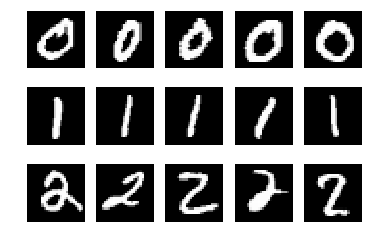

In [1]:
# Classifying images of handwritten numbers
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
import matplotlib.cm as cm

# Fetch the data
mnist = fetch_mldata('MNIST original', data_home='data/mnist')

# Create subplots of 5 images of the digits 0, 1, & 2
counter = 1
for i in range(1, 4):
    for j in range(1, 6):
        plt.subplot(3, 5, counter)
        plt.imshow(mnist.data[(i - 1) * 8000 + j].reshape((28, 28)), cmap=cm.Greys_r)
        plt.axis('off')
        counter += 1
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# The script will fork additional processes during GridSearch,
# which requires execution from a main block
if __name__ == '__main__':
    # Scale features and center about the origin
    X, y = mnist.data, mnist.target
    X = X/255.0*2 - 1
    # Split pre-processed data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)
    
    # Establish a pipeline using SVC (support vector classifier)
    # Kernal is set to use radial basis fuction
    # 'C' controls regularisation
    # NOTE: the keywork argument 'degree' should also be set when polynomial kernel is used
    pipeline = Pipeline([
        ('clf', SVC(kernel='rbf', gamma=0.01, C=100))
    ])
    
    parameters = {
        'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
        'clf__C': (0.1, 0.3, 1, 3, 10, 30),
    }
    
    # Tune parameters using gridsearch. This will take a while
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=2, verbose=1, scoring='accuracy')
    
    # Train the model and print the best scores
    grid_search.fit(X_train[:10000], y_train[:10000])
    print('Best score: %0.3f' % grid_search.best_score_)
    print('Best parameters set:')
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    
    predictions = grid_search.predict(X_test)
    print(classification_report(y_test, predictions))

In [ ]:
# Classifying characters in natural images
# The dataset can be found at: http://ee.surrey.ac.uk/CVSSP/chars74k/
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from PIL import Image

# Convert images to greyscale using 'pillow' and resize before
# adding them to a numpy array
X = []
y = []
for path, subdirs, files in os.walk('data/English/Img/GoodImg/Bmp/'):
    for filename in files:
        f = os.path.join(path, filename)
        target = filename[3:filename.index('-')]
        img = Image.open(f).convert('L').resize((30, 30), resample=Image.LANCZOS)
        X.append(np.array(img).reshape(900,))
        y.append(target)
X = np.array(X)

In [ ]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=11)

# Create SVC instance and parameters
pipeline = Pipeline([
    ('clf', SVC(kernel='rbf', gamma=0.01, C=100))
])
parameters = {
    'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
    'clf__C': (0.1, 0.3, 1, 3, 10, 30),
}

# Fork the main block and run the model
if __name__ == '__main__':
    # GridSearch to tune the parameters and evaluate the model on the test data
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=3, verbose=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print('Best score: %0.3f' % grid_search.best_score_)
    print('Best parameters set:')
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    predictions = grid_search.predict(X_test)
    print(classification_report(y_test, predictions))